In [14]:
import pandas_ta as ta
import math

import datetime as dt
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import gc


import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import utils

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

from process_data import process_financial_data
import os

import gc
gc.collect()



17976

In [15]:
directory = 'data_final/final_stocks'
predictions_df = pd.DataFrame()
returns_df = pd.DataFrame()
all_results = []
selected = ['SMA Close (S)', 'EMA Close (S)', 'LowR', 'OpenR (3)', 'CloseR (30)',
       'LowR (30)', 'High/Open', 'High/Close (1)', 'Low/Close (2)',
       'Low/Open (3)', 'Low/Open (2/3)', 'Low/Open (30/30)',
       'High/Close (30/30)', 'High/Open (35/35)', 'Low/Close (37/40)',
       'Low/Open (38/40)', 'High/Close (38/40)', 'High/Open (40/40)',
       'RetClose (20)', 'RetClose (30)', 'RetClose (40)', 'RetLow (5)',
       'RetLow (30)', 'RetHigh (30)', 'RetOpen (30)']

results = []


In [16]:
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        data = pd.read_csv(file_path)
        data.drop(['Adj Close', 'Volume'], axis= 1, inplace= True)
        data['CloseR']= data['Close']/data['Close'].shift(-1) # target feature we want to predict
        data = process_financial_data(data)
        newdata= data[selected]

        ## Scaling the Input Data for Training and Testing
        scaler = MinMaxScaler(feature_range=(0, 1))
        ts_scaled = scaler.fit_transform(newdata)  # Fit and transform training data

        # Use transform (not fit_transform) on prediction data subset
        pred_data= data[newdata.columns]
        pred_data= pred_data[len(data)-15:]

        pred_scaled= scaler.fit_transform(pred_data)

        # Target data should be scaled separately but only fit once
        TargetReturns= data['TargetCloseR'][:len(data)-15].values.reshape(-1,1)
        scaler2= MinMaxScaler(feature_range= (0,1))
        scaled2= scaler2.fit_transform(TargetReturns)


        ## Creating a time series dataset for LSTM
        days= 72
        X= []

        for j in range(25):
            X.append([])
            for i in range(days, len(ts_scaled)):
                X[j].append(ts_scaled[i-days:i, j])

        X, yi= np.array(X), np.array(scaled2[days:, 0])
        X= np.moveaxis(X, [0], [2]) 
        y= np.reshape(yi, (len(yi), 1))

        ## Splitting data (80% training, 20% testing)
        split= int(len(X)* 0.8)

        x_train, x_test= X[:split], X[split:]
        y_train, y_test= y[:split], y[split:]

        # Model Definition (reinitialize the model in each loop)
        model = Sequential([
            LSTM(120, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(0.1),
            LSTM(170, return_sequences=True),
            Dropout(0.1),
            LSTM(50),
            Dropout(0.1),
            Dense(1, activation='relu')
        ])

        # Model Training
        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1)
        model.compile(optimizer='adam', loss='mean_squared_error')
        history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[rlr], validation_split=0.2, shuffle=True)

        # Prediction
        test_predict = model.predict(x_test)
        test_predict= scaler2.inverse_transform(test_predict)
        returnss= scaler2.inverse_transform(y_test)

        # Store metrics
        stock_name = filename.replace('.csv', '')
        final_epoch = len(history.history['loss'])
        final_loss = history.history['loss'][-1]
        final_val_loss = history.history['val_loss'][-1]
        final_lr = float(model.optimizer.lr.numpy())  # Ensure it's a float for serialization

        # Append results to the list
        results.append({
            'Stock': stock_name,
            'Final Loss': final_loss,
            'Validation Loss': final_val_loss,
            'Final Learning Rate': final_lr,
            'Epochs Run': final_epoch
        })

        stock_name = filename.replace('.csv', '')
        predictions_df[stock_name] = pd.Series(test_predict.flatten())
        returns_df[stock_name] = pd.Series(returnss.flatten())
        


CloseR Column: 0
DataFrame Shape: (2273, 168)
Epoch 1/100
57/57 [==============================] - 3s 18ms/step - loss: 0.0133 - val_loss: 0.0023 - lr: 0.0010
Epoch 2/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0022 - lr: 0.0010
Epoch 3/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0046 - val_loss: 0.0022 - lr: 0.0010
Epoch 4/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0022 - lr: 0.0010
Epoch 5/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0022 - lr: 0.0010
Epoch 6/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0044 - val_loss: 0.0023 - lr: 0.0010
Epoch 7/100
57/57 [==============================] - 0s 9ms/step - loss: 0.0045 - val_loss: 0.0021 - lr: 0.0010
Epoch 8/100
57/57 [==============================] - 0s 8ms/step - loss: 0.0045 - val_loss: 0.0021 - lr: 0.0010
Epoch 9/100
57/57 [==============================] - 0s 8

In [17]:
metrics_df = pd.DataFrame(results)
metrics_df.to_csv('data_final/final_metrics.csv')


In [8]:
predictions_df.to_csv('data_final/preds.csv')
returns_df.to_csv('data_final/real.csv')


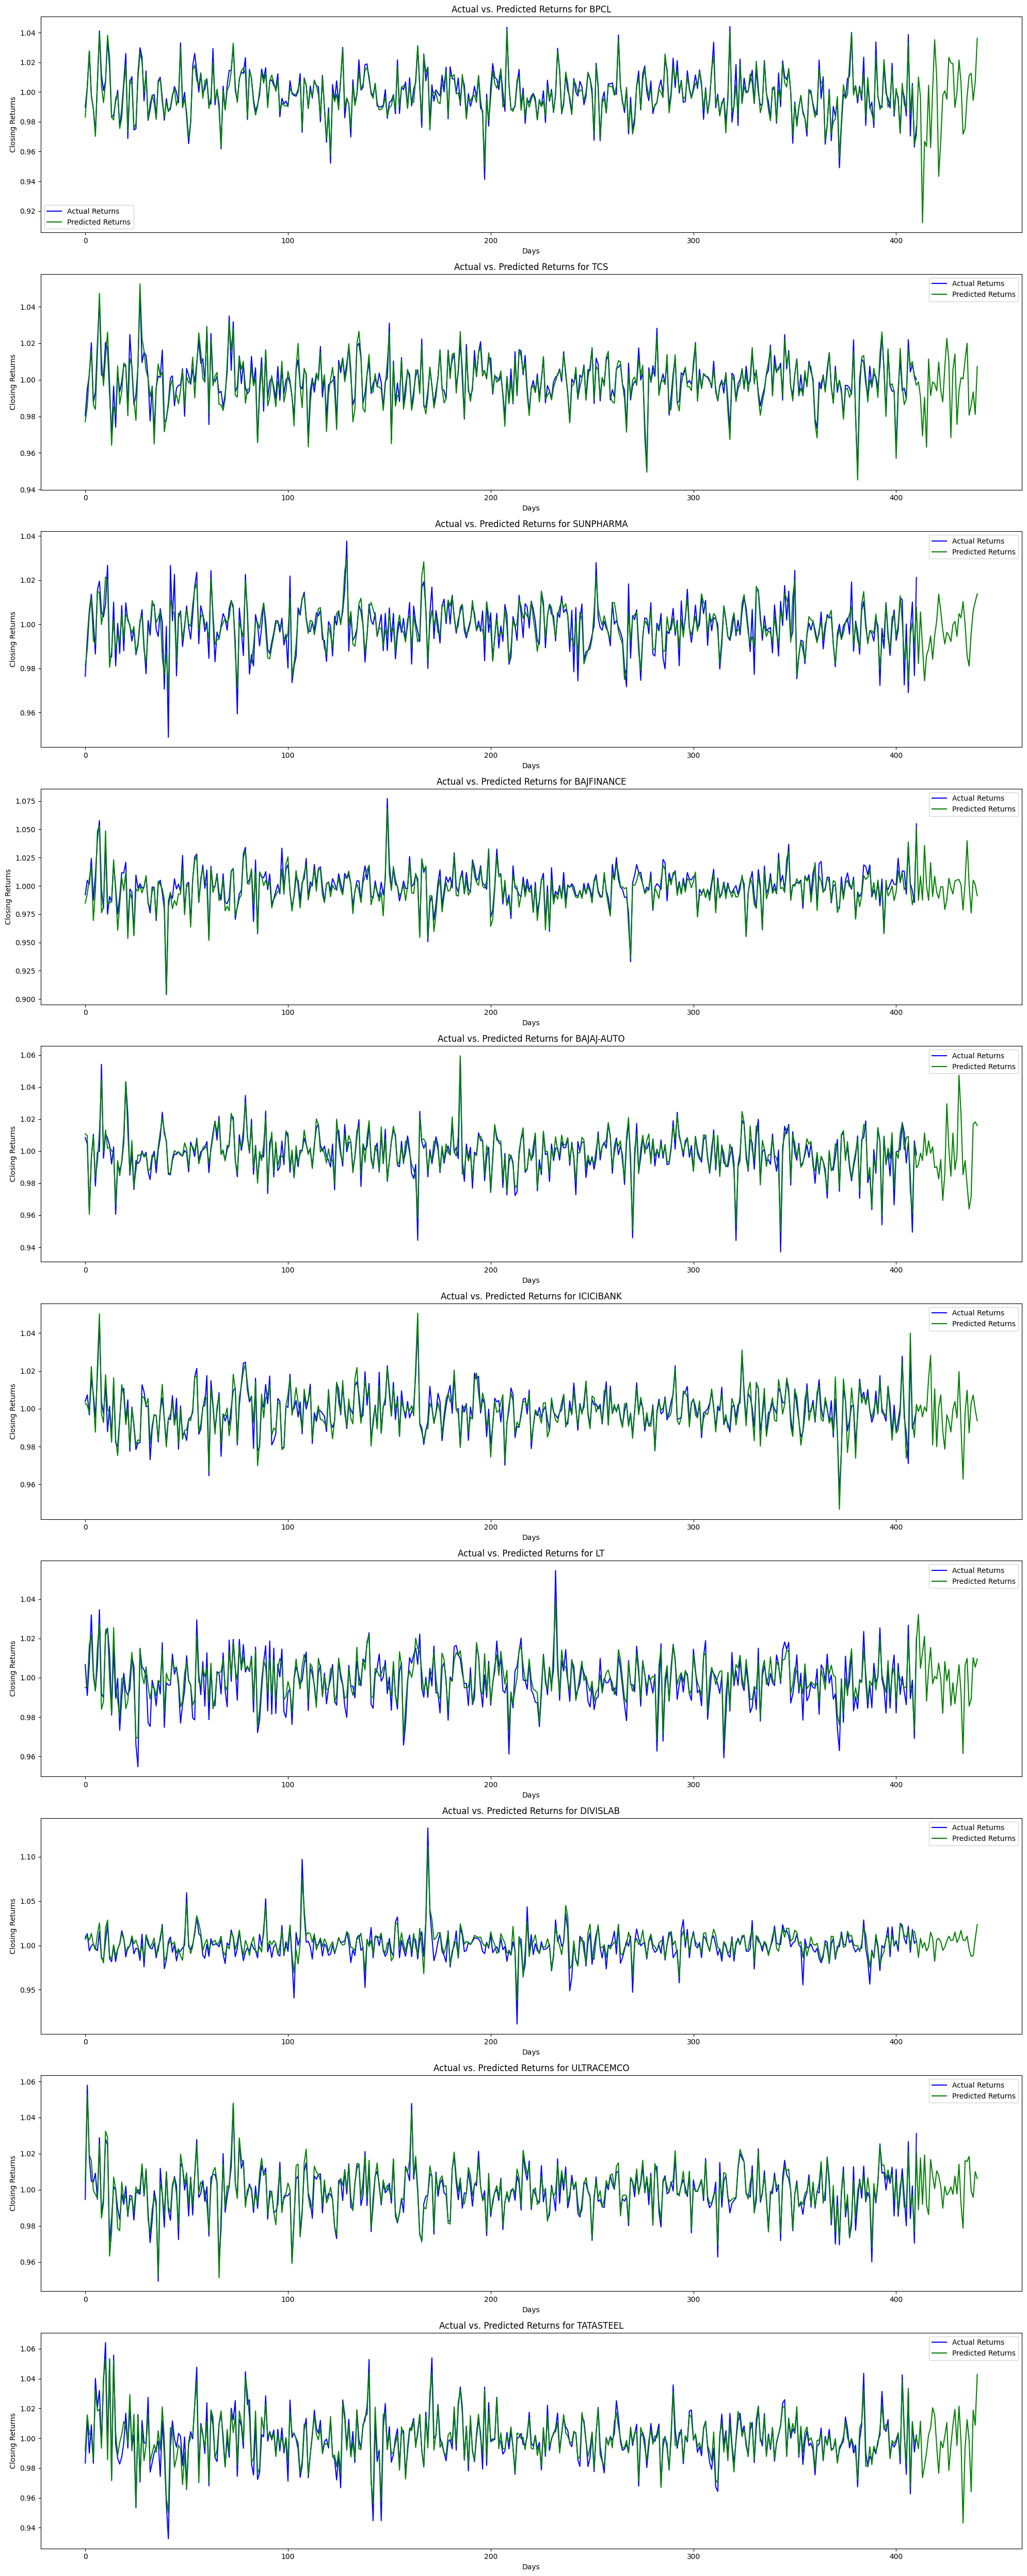

In [6]:
plt.figure(figsize=(20, 50))

# Loop over each column in the dataset
for i, stock in enumerate(returns_df.columns):  # Now directly using column names
    plt.subplot(len(returns_df.columns), 1, i+1)  # Create a subplot for each stock
    plt.plot(returns_df[stock], color='blue', label='Actual Returns')
    plt.plot(predictions_df[stock], color='green', label='Predicted Returns')
    plt.title(f'Actual vs. Predicted Returns for {stock}')
    plt.xlabel('Days')
    plt.ylabel('Closing Returns')
    plt.legend()

plt.tight_layout()
plt.show()

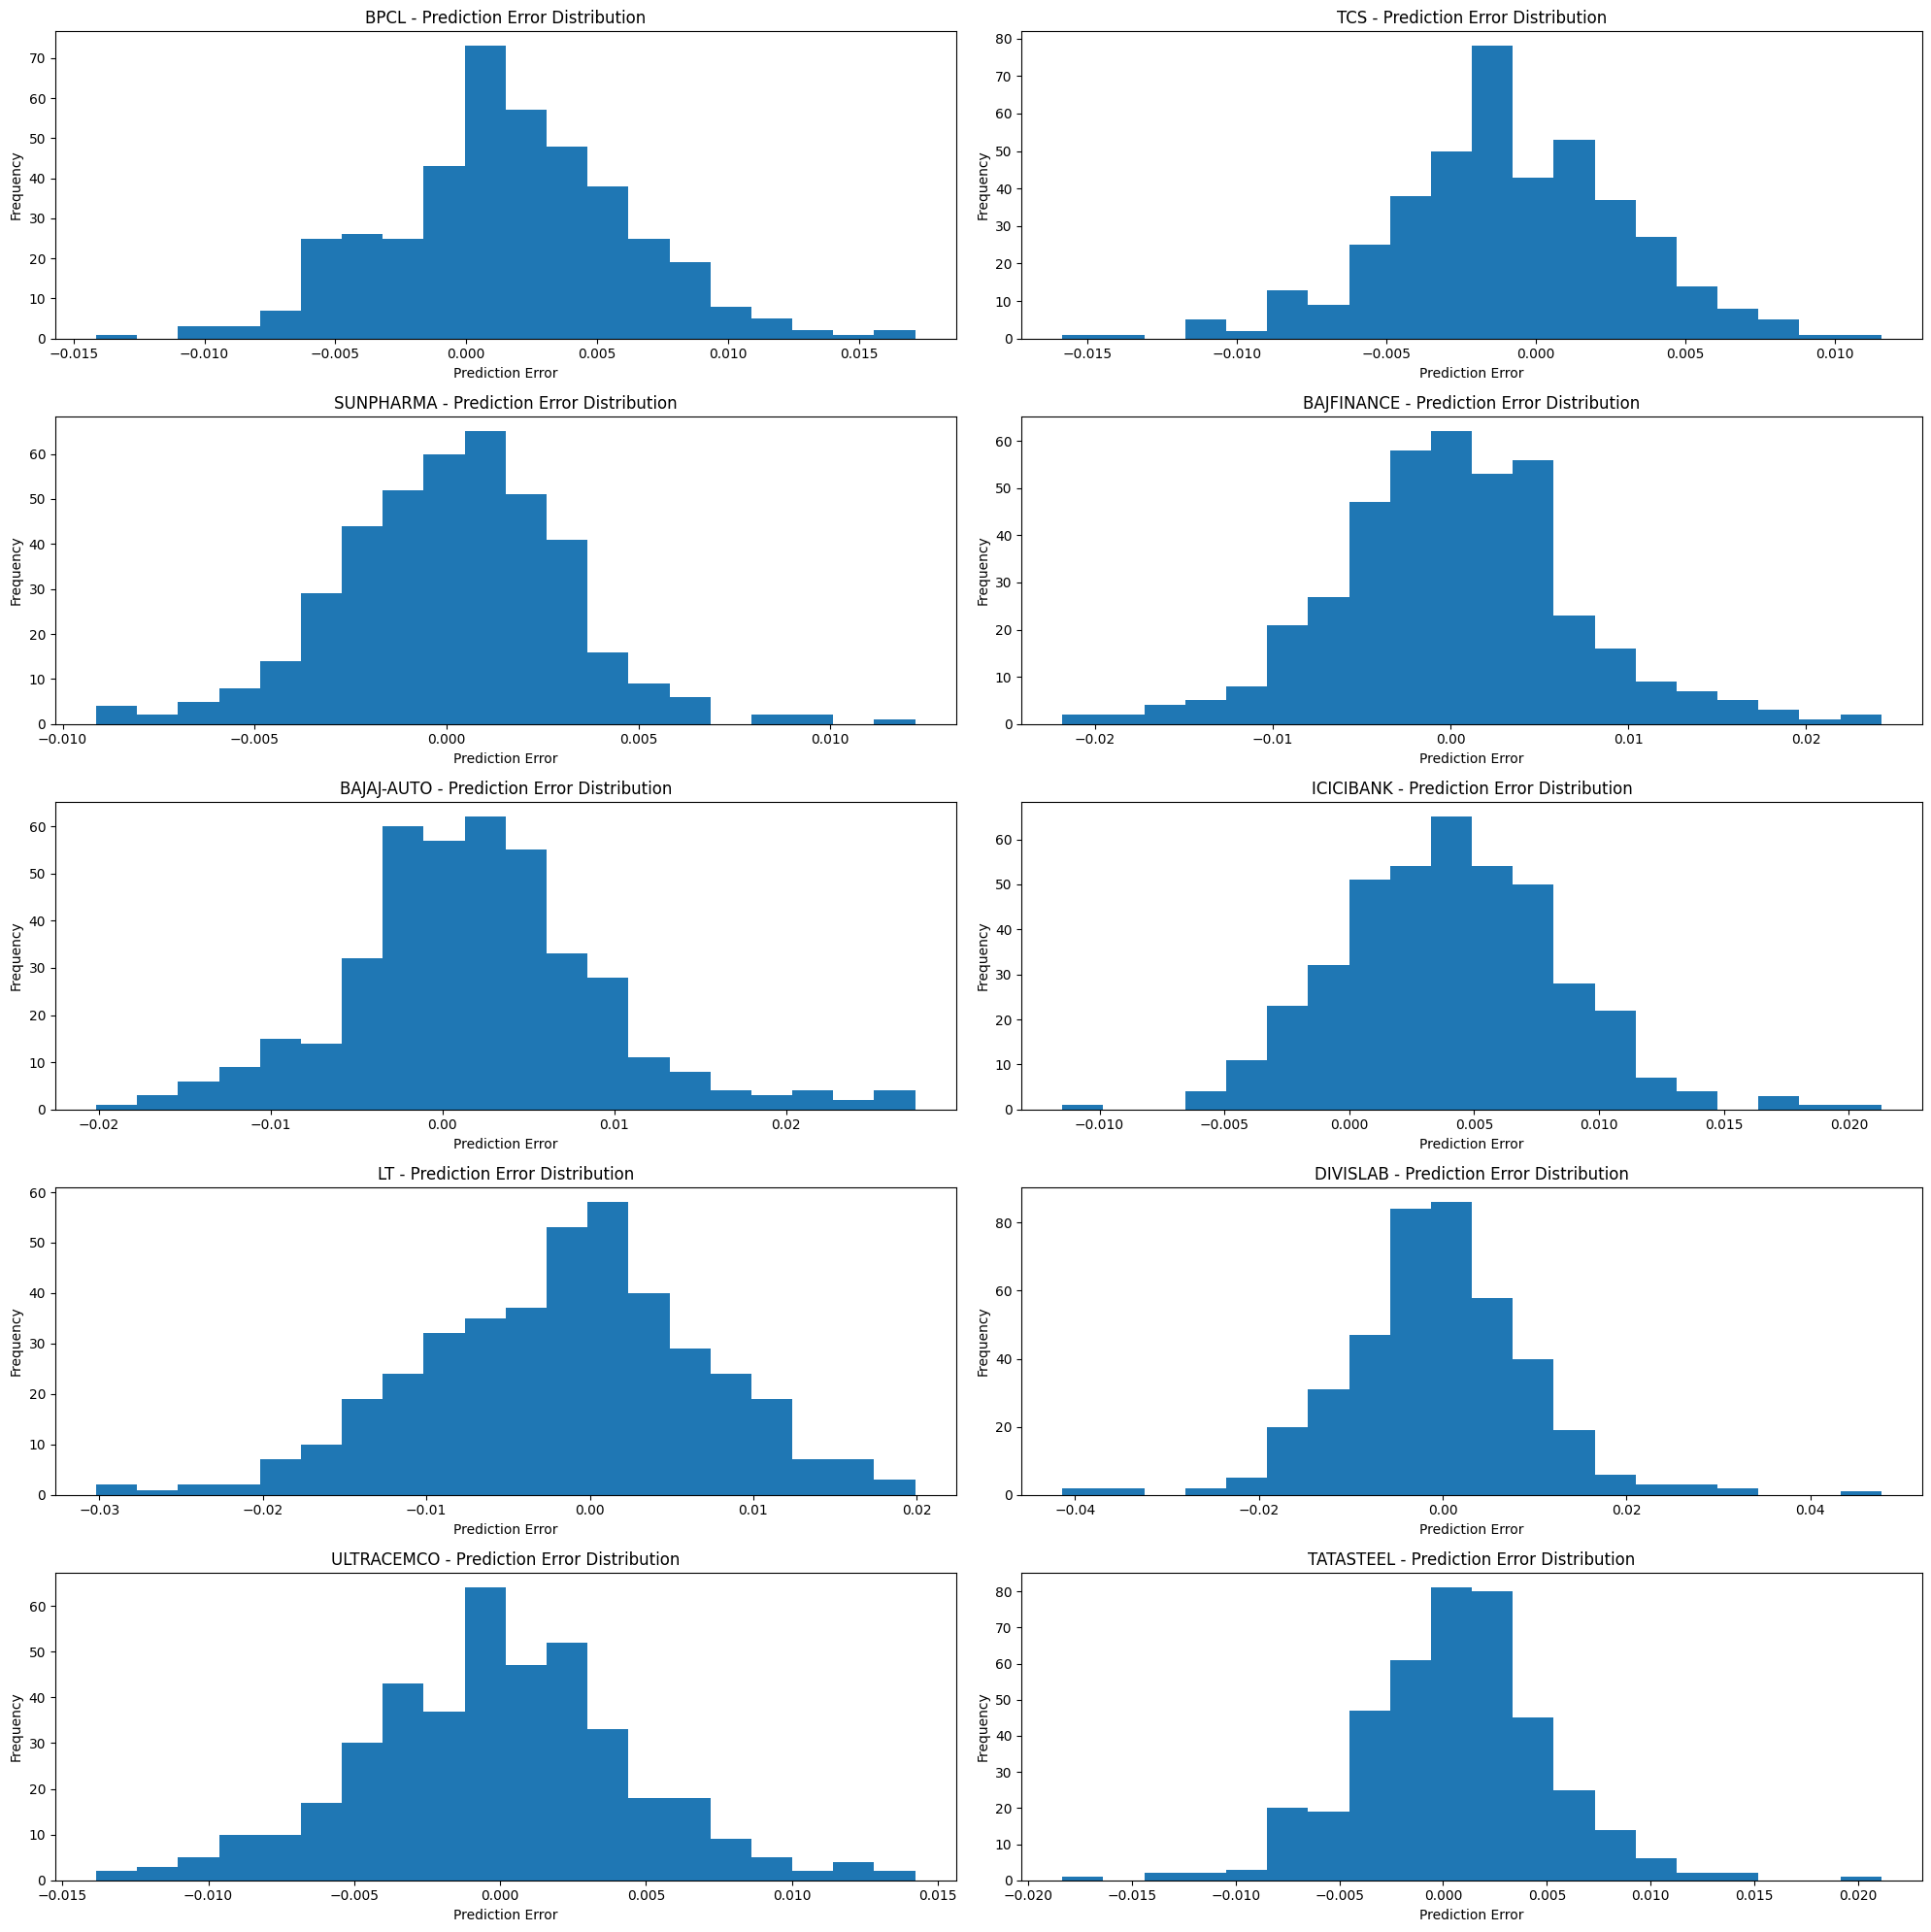

In [8]:
plt.figure(figsize=(20, 20))  # Adjust figsize as needed for better visibility

# Assuming 'returns_df' and 'predictions_df' have the same columns representing stock symbols
for i, stock in enumerate(returns_df.columns):
    plt.subplot(5, 2, i + 1)  # 5x2 grid, change indices accordingly

    errors = predictions_df[stock] - returns_df[stock]  # Calculate prediction errors

    plt.hist(errors, bins=20)  # Create histogram of errors
    plt.title(stock + ' - Prediction Error Distribution')  # Title with stock symbol
    plt.xlabel('Prediction Error')  # Label for the x-axis
    plt.ylabel('Frequency')        # Label for the y-axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()